# Regolarizzazione: Esercitazione
Per questa esercitazione dovrai verificare la presenza di overfitting e regolarizzare un modello di regressione polinomiale di secondo grado. Il modello utilizzerà il Boston Housing Dataset, che puoi scaricare [da qui](https://raw.githubusercontent.com/ProfAI/machine-learning-fondamenti/main/datasets/housing.csv), per stimare il valore di abitazioni.

Il modello dovrà avere:
1. Un R2 sul set di test di almeno 0.75.
2. Un R2 calcolato tramite cross validation di almeno 0.8.

Inoltre, la differenza tra R2 sul set di addestramento e sul set di test deve essere inferiore del 15% (ad esempio, per un R2 sul set di addestramento di 1, l'R2 sul set di test non deve essere inferiore a 0.85).



In [1]:
RANDOM_SEED = 0 #for reproducibility

In [2]:
#data import
import pandas as pd
import numpy as np

URL = "https://raw.githubusercontent.com/ProfAI/machine-learning-fondamenti/main/datasets/housing.csv"

data = pd.read_csv(URL,index_col=0)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
#modello di regressione polinomiale di 2 grado -> ho bisogno del 
#PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

X = data.drop("PRICE", axis = 1).values
y = data["PRICE"].values

pf = PolynomialFeatures(2)

#X_p = pf.fit_transform(X)
#pf.get_feature_names_out()

In [4]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X, y):
    
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    print(f"MSE: {mse:.3f}\nR2: {r2:.3f}")

Prova senza regolarizzazione

In [5]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                   random_state = RANDOM_SEED)

X_train_p = pf.fit_transform(X_train)
X_test_p = pf.transform(X_test) #qui solo transform?

#uso scaling per portare le variabili su stessa scala.
#uso standard scaler per conservare le info sugli outlier e mantenere
#distribuzione dei dati.

ss = StandardScaler()
X_train_p = ss.fit_transform(X_train_p)
X_test_p = ss.transform(X_test_p)

lr = LinearRegression()

lr.fit(X_train_p,y_train)

print("Polynomial regression, without regularization - Hold out")
print("Train set:")
evaluate_model(lr,X_train_p,y_train)
print("Test set:")
evaluate_model(lr,X_test_p,y_test)

Polynomial regression, without regularization - Hold out
Train set:
MSE: 4.100
R2: 0.952
Test set:
MSE: 30.034
R2: 0.639


Tra i due set ho differenza di $R^2$ di circa $30\%$.
Sul test set ho $R^2=65\%$; Devo portarlo almeno al $75\%$.

Valutazione con la cross validazione.

In [6]:
from sklearn.model_selection import KFold

mse_train_scores=np.array([])
mse_test_scores=np.array([])
r2_train_scores=np.array([])
r2_test_scores=np.array([])

#nella cross validazione provo con k = 5
kf = KFold(n_splits = 5, shuffle=True, random_state = RANDOM_SEED)

for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    X_train_p = pf.fit_transform(X_train)
    X_test_p = pf.transform(X_test)
    
    ss = StandardScaler()
    X_train_p = ss.fit_transform(X_train_p)
    X_test_p = ss.transform(X_test_p)
    
    lr = LinearRegression()
    lr = lr.fit(X_train_p,y_train)
    
    y_train_predict = lr.predict(X_train_p)
    y_test_predict = lr.predict(X_test_p)
    
    mse_train_scores = np.append(mse_train_scores, mean_squared_error(y_train, y_train_predict))
    #mse_train_scores.append(mean_squared_error(y_train, y_train_predict))
    r2_train_scores = np.append(r2_train_scores, r2_score(y_train, y_train_predict))
    #r2_train_scores.append(r2_score(y_train, y_train_predict))
    
    mse_test_scores = np.append(mse_test_scores, mean_squared_error(y_test, y_test_predict))
    #mse_test_scores.append(mean_squared_error(y_test, y_test_predict))
    r2_test_scores = np.append(r2_test_scores, r2_score(y_test, y_test_predict))
    #r2_test_scores.append(r2_score(y_test, y_test_predict))
    
    #end for

mse_train = np.mean(mse_train_scores)
r2_train = np.mean(r2_train_scores)
mse_test = np.mean(mse_test_scores)
r2_test = np.mean(r2_test_scores)

print("Polynomial regression, without regularization - KFold cross validation")
print("Train set:")
print(f"MSE:{mse_train:.3f}\nR2: {r2_train:.3f}")
print("Test set:")
print(f"MSE:{mse_test:.3f}\nR2: {r2_test:.3f}")

Polynomial regression, without regularization - KFold cross validation
Train set:
MSE:6.733
R2: 0.920
Test set:
MSE:22.025
R2: 0.732


Con cross validazione del modello polinomiale standard ottengo una differenza tra i due $R^2$ del $20\%$ circa.
Anche l'MSE è abbastanza diverso -> ho overfitting.

È richiesto un $R^2$ di almeno $80\%$ sul test set.

### regolarizzazioni varie
ripeto il processo di valutazione con il modello Lasso e Ridge.
Mi aspetto situazione migliore con il modello Lasso (L1).

In [7]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                   random_state = RANDOM_SEED)

X_train_p = pf.fit_transform(X_train)
X_test_p = pf.transform(X_test)

ss = StandardScaler()
X_train_p = ss.fit_transform(X_train_p)
X_test_p = ss.transform(X_test_p)

#uso valore di alpha = 15, ma in realtà bisognerebbe ragionarci sù,
#valutando anche la scala su cui si muovono le variabili e i pesi.
#Per questo motivo è meglio usare uno scaling delle features.
model = Ridge(alpha=15.)
model.fit(X_train_p, y_train)

print("Polynomial regression, L2 regularization - Hold out")
print("Train set:")
evaluate_model(model,X_train_p,y_train)
print("Test set:")
evaluate_model(model,X_test_p,y_test)

Polynomial regression, L2 regularization - Hold out
Train set:
MSE: 9.667
R2: 0.886
Test set:
MSE: 17.933
R2: 0.785


Con regolarizzazione L2 ottengo valori più simili tra test set e train set, rispetto ai casi precedenti.
Questo indica che l'overfitting è ridotto.
La differenza tra i due $R^2$ è attorno $10\%$ con hold-out. 

Vediamo cosa succede con L1.

In [8]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                   random_state = RANDOM_SEED)

X_train_p = pf.fit_transform(X_train)
X_test_p = pf.transform(X_test)

ss = StandardScaler()
X_train_p = ss.fit_transform(X_train_p)
X_test_p = ss.transform(X_test_p)

#uso valore di alpha = 5, ma in realtà bisognerebbe ragionarci sù,
#valutando anche la scala su cui si muovono le variabili e i pesi.
#Per questo motivo è meglio usare uno scaling delle features.
model = Lasso(alpha=5.) 
#per il lasso uso valore più piccolo del ridge, 
#perchè tale algoritmo è più forte del ridge.
model.fit(X_train_p, y_train)

print("Polynomial regression, L1 regularization - Hold out")
print("Train set:")
evaluate_model(model,X_train_p,y_train)
print("Test set:")
evaluate_model(model,X_test_p,y_test)

Polynomial regression, L1 regularization - Hold out
Train set:
MSE: 56.913
R2: 0.329
Test set:
MSE: 57.555
R2: 0.309


Con la regolarizzazione L1 ottengo valori simili tra train e test, sia per $R^2$ che per MSE, il che indica un overfitting ben gestito. 
D'altra parte però le performance non sono buone, infatti MSE è elevato e $R^2$ è basso. 

Questo significa che la regolarizzazione è stata troppo forte e quindi sono in underfitting ora. Bisogna usare un alpha ancora più piccolo.

Seleziono come modello il Ridge. Non uso il LASSO perchè è troppo forte e può portare facilmente ad underfitting.
Valuto questo modello con $\alpha=15$ con KFold.

In [9]:
mse_train_scores=np.array([])
mse_test_scores=np.array([])
r2_train_scores=np.array([])
r2_test_scores=np.array([])

#nella cross validazione provo con k = 5
kf = KFold(n_splits = 5, shuffle=True, random_state = RANDOM_SEED)

for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    X_train_p = pf.fit_transform(X_train)
    X_test_p = pf.transform(X_test)
    
    ss = StandardScaler()
    X_train_p = ss.fit_transform(X_train_p)
    X_test_p = ss.transform(X_test_p)
    
    mod_k_fold = Ridge(alpha=15.)
    mod_k_fold.fit(X_train_p,y_train)
    
    y_train_predict = mod_k_fold.predict(X_train_p)
    y_test_predict = mod_k_fold.predict(X_test_p)
    
    mse_train_scores = np.append(mse_train_scores, mean_squared_error(y_train, y_train_predict))
    #mse_train_scores.append(mean_squared_error(y_train, y_train_predict))
    r2_train_scores = np.append(r2_train_scores, r2_score(y_train, y_train_predict))
    #r2_train_scores.append(r2_score(y_train, y_train_predict))
    
    mse_test_scores = np.append(mse_test_scores, mean_squared_error(y_test, y_test_predict))
    #mse_test_scores.append(mean_squared_error(y_test, y_test_predict))
    r2_test_scores = np.append(r2_test_scores, r2_score(y_test, y_test_predict))
    #r2_test_scores.append(r2_score(y_test, y_test_predict))
    
    #end for

mse_train = np.mean(mse_train_scores)
r2_train = np.mean(r2_train_scores)
mse_test = np.mean(mse_test_scores)
r2_test = np.mean(r2_test_scores)

print("Polynomial regression, L2 regularization - KFold cross validation")
print("Train set:")
print(f"MSE:{mse_train:.3f}\nR2: {r2_train:.3f}")
print("Test set:")
print(f"MSE:{mse_test:.3f}\nR2: {r2_test:.3f}")

Polynomial regression, L2 regularization - KFold cross validation
Train set:
MSE:10.913
R2: 0.870
Test set:
MSE:14.496
R2: 0.821


Questo modello rispetta le specifiche della consegna.

Con hold-out si ha $R^2=78\%$ sul test set.

Con KFold si ha $R^2=82\%$ sul test set.

In ogni caso la differenza tra test set e train set è sempre minore del $15\%$

### Learning curve

Per questo modello, costruisco la learning curve (per completezza)

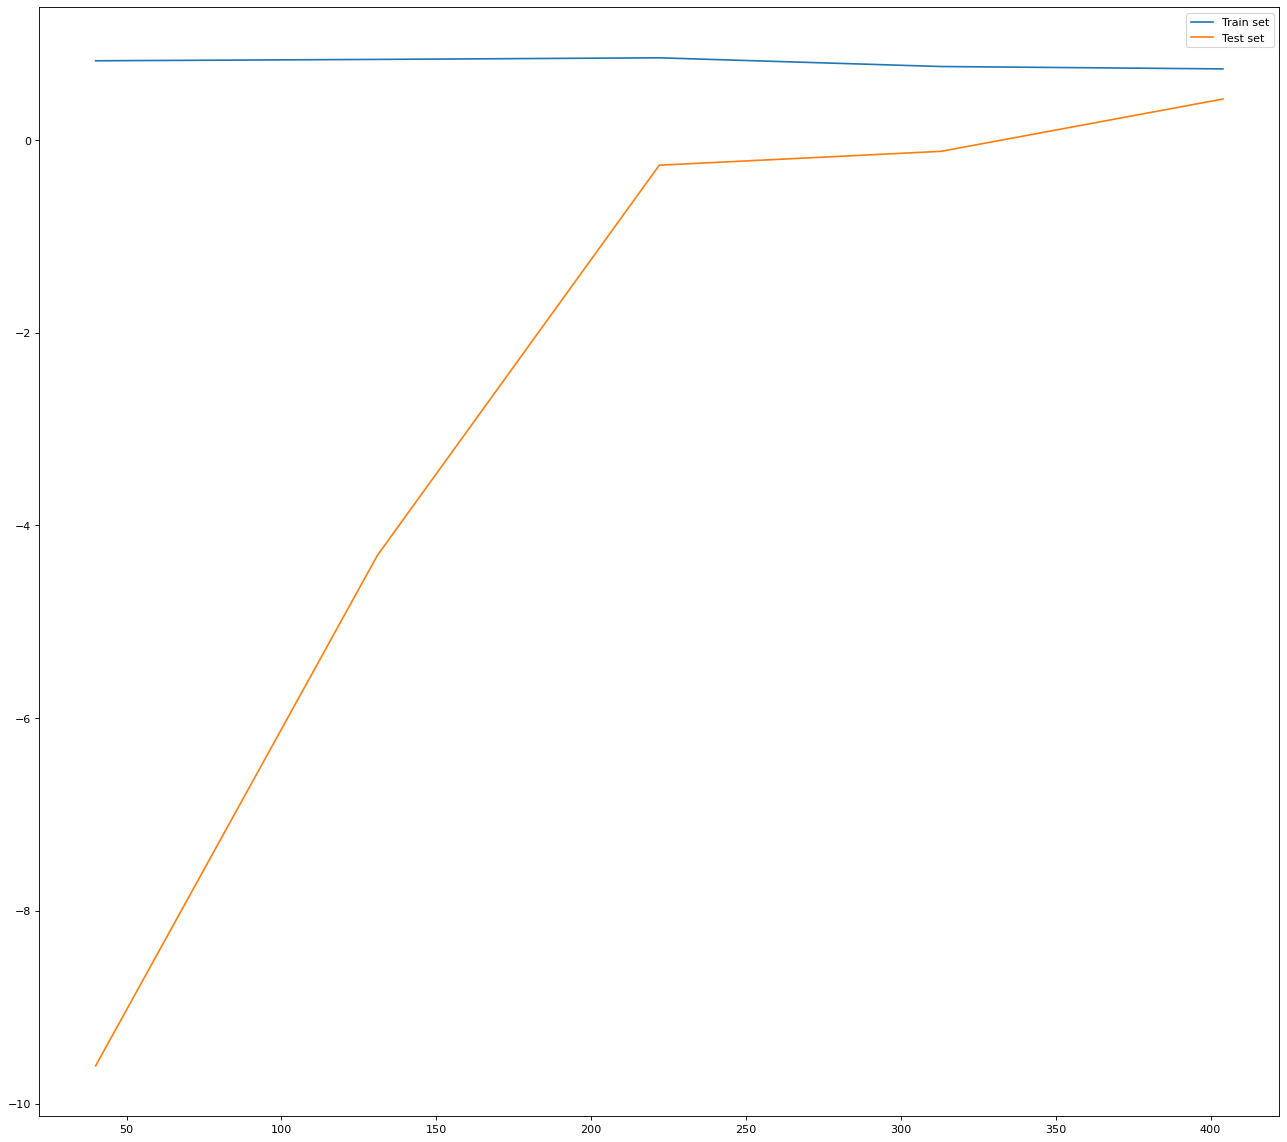

In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_size_abs, train_scores, test_scores = learning_curve(
    Ridge(alpha=10.),X,y
)

plt.figure(figsize=(20,18),dpi=80)

plt.plot(train_size_abs,train_scores.mean(axis=1),label="Train set")
plt.plot(train_size_abs,test_scores.mean(axis=1),label="Test set")
plt.legend()
plt.show()